# Coding: Machine Translation with Transformer

 - Dataset: wmt-17, en-zh, select 1m high-quality pairs of data
 - Model: Seq2seq with Transformer (Attention is all you need)
 - GPU: 1660TI

In [1]:
# 可以先测试网络连接
import requests
try:
    response = requests.get("https://huggingface.co")
    print("网络连接正常")
except:
    print("网络连接可能存在问题")

网络连接正常


In [2]:
# Download the data & select 5m high-quality pairs

from datasets import load_dataset
import re

# load full wmt-17 en-zh dataset
full_dataset = load_dataset("wmt/wmt17", "zh-en", split="train", cache_dir=r"D:\Developer\LLM\FuggingFace-cache-model")

# Length & Ratio filter
def is_high_quality(x):
    import re  # 添加这一行
    en = x["translation"]["en"]
    zh = x["translation"]["zh"]
    if not en or not zh:
        return False
    if len(en) < 3 or len(zh) < 3:
        return False
    if len(en) > 100 or len(zh) > 100:
        return False
    ratio = len(en) / len(zh)
    if ratio < 0.5 or ratio > 2:
        return False
    if not re.search(r'[\u4e00-\u9fff]', zh):
        return False
    return True

filtered_dataset = full_dataset.filter(is_high_quality, num_proc=10)

# 选出最多500万条数据
dataset = filtered_dataset.select(range(min(5_000_000, len(filtered_dataset))))

print("Full Dataset Size: ", len(full_dataset))
print("Filtered Dataset Size: ", len(filtered_dataset))
print("Dataset Size: ", len(dataset))

# print 10 samples
sample = dataset.shuffle(seed=42).select(range(10))
print("-"*100)
for i in sample:
    print(i["translation"]["en"])
    print(i["translation"]["zh"])
    print("-"*100)

Full Dataset Size:  25134743
Filtered Dataset Size:  1141860
Dataset Size:  1141860
----------------------------------------------------------------------------------------------------
Zambia (7)
赞比亚(7)
----------------------------------------------------------------------------------------------------
15:00 to 18:00 Informal consultations (closed) Conference Room 5 (NLB)
下午3:00－6:00 非正式磋商(闭门会议) 第5会议室(北草坪会议大楼)
----------------------------------------------------------------------------------------------------
Spain
西班牙
----------------------------------------------------------------------------------------------------
Mr. Robert Morrison
Robert Morrison先生 加拿大自然资源部
----------------------------------------------------------------------------------------------------
This satisfied the kids, but not the husband.
"孩子们得到了满意的答案, 但她的丈夫却没有。
----------------------------------------------------------------------------------------------------
Shutaro Omura (Japan)
Shutaro Omura（日本）
---------------

In [3]:
# Create PyTorch Dataset and DataLoader for training

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# 继承Dataset构建英中文翻译数据集
class TranslationDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer_en, tokenizer_zh, max_length=100):
        """
        PyTorch Dataset wrapper for HuggingFace translation dataset

        Args:
            hf_dataset: HuggingFace dataset with translation pairs
            tokenizer_en: English tokenizer (optional, can be added later)
            tokenizer_zh: Chinese tokenizer (optional, can be added later)
            max_length: Maximum sequence length
        """
        self.dataset = hf_dataset
        self.tokenizer_en = tokenizer_en
        self.tokenizer_zh = tokenizer_zh
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        en_text = item["translation"]["en"]
        zh_text = item["translation"]["zh"]

        # 对英文文本进行tokenizer，截取max_length，不够会进行填充，返回pytorch张量
        en_tokens = self.tokenizer_en(en_text,
                                        max_length=self.max_length,
                                        padding='max_length',
                                        truncation=True,
                                        return_tensors='pt')

        # 对中文文本进行tokenizer，截取max_length，不够会进行填充，返回pytorch张量
        zh_tokens = self.tokenizer_zh(zh_text,
                                        max_length=self.max_length,
                                        padding='max_length',
                                        truncation=True,
                                        return_tensors='pt')

        # 返回数据结构
        return {
                'source_ids': en_tokens['input_ids'].squeeze(),     # 去除张量的多余维度，输出以为数字数组，文本对应的tokenizer后的数组
                'target_ids': zh_tokens['input_ids'].squeeze(),
                'source_text': en_text,         # 原始文本
                'target_text': zh_text
        }

# 构建训练和验证数据集
def create_dataloaders(dataset, batch_size=128, num_workers=0, train_split=0.95):
    """
    Create train and validation DataLoaders from HuggingFace dataset

    Args:
        dataset: HuggingFace dataset with translation pairs
        batch_size: Batch size for DataLoaders
        num_workers: Number of worker processes for data loading
        train_split: Fraction of data to use for training

    Returns:
        train_dataloader, val_dataloader, train_dataset, val_dataset
    """

    # Split dataset into train and validation
    train_size = int(train_split * len(dataset))

    # Create indices for splitting
    indices = list(range(len(dataset)))
    train_indices, val_indices = train_test_split(indices,
                                                train_size=train_size,
                                                random_state=42)

    # Create train and validation datasets
    train_dataset_hf = dataset.select(train_indices)
    val_dataset_hf = dataset.select(val_indices)

    # tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
    tokenizer_en = AutoTokenizer.from_pretrained("bert-base-uncased")
    tokenizer_zh = AutoTokenizer.from_pretrained("bert-base-chinese")

    # get vocab sizes
    vocab_size_en = tokenizer_en.vocab_size
    vocab_size_zh = tokenizer_zh.vocab_size

    print(f"Vocab size for en: {vocab_size_en}")
    print(f"Vocab size for zh: {vocab_size_zh}")

    # Create PyTorch datasets， 得到tokenizer后的训练数据集和验证数据集
    train_dataset = TranslationDataset(train_dataset_hf, tokenizer_en, tokenizer_zh)
    val_dataset = TranslationDataset(val_dataset_hf, tokenizer_en, tokenizer_zh)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")

    # Create DataLoaders 创建了pytorch数据加载器，封装了数据集，并定义了batch_size，shuffle，num_workers，方便训练时设置数据加载相关的超参数
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"Train DataLoader: {len(train_dataloader)} batches")
    print(f"Validation DataLoader: {len(val_dataloader)} batches")

    return train_dataloader, val_dataloader, vocab_size_en, vocab_size_zh

def test_dataloader(dataloader):
    """Test the DataLoader by printing a sample batch"""
    print("\n" + "="*50)
    print("Sample batch from DataLoader:")
    print("="*50)

    for batch in dataloader:
        print(f"Batch size: {len(batch['source_text'])}")
        print(f"Source example: {batch['source_text'][0]}")
        print(f"Source tokens: {batch['source_ids'][0]}")
        print(f"Target example: {batch['target_text'][0]}")
        print(f"Target tokens: {batch['target_ids'][0]}")
        break

train_dataloader, val_dataloader, encoder_vocab_size, decoder_vocab_size = create_dataloaders(dataset, batch_size=64)
test_dataloader(train_dataloader)
test_dataloader(val_dataloader)

Vocab size for en: 30522
Vocab size for zh: 21128
Train dataset size: 1084767
Validation dataset size: 57093
Train DataLoader: 16950 batches
Validation DataLoader: 893 batches

Sample batch from DataLoader:
Batch size: 64
Source example: para. 128
Source tokens: tensor([  101, 11498,  1012, 11899,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,

In [4]:
# Define the Transformer model for Machine Translation
# Following "Attention is All You Need" architecture

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0 # 模型维度必须能被注意力头数整除，模型维度就相当于是每个token在embedding编码后的维度

        self.d_model = d_model  # 模型维度 (int)
        self.num_heads = num_heads  # 注意力头数 (int)
        self.d_k = d_model // num_heads # 每个注意力头维度 (int)

        self.W_q = nn.Linear(d_model, d_model)  # 查询权重矩阵 (d_model × d_model)
        self.W_k = nn.Linear(d_model, d_model)  # 键权重矩阵 (d_model × d_model)
        self.W_v = nn.Linear(d_model, d_model)  # 值权重矩阵 (d_model × d_model)
        self.W_o = nn.Linear(d_model, d_model)  # 输出权重矩阵 (d_model × d_model)

        # dropout 层
        self.dropout = nn.Dropout(dropout)

    # 实现缩放点积注意力机制。
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Calculate attention scores 计算注意力分值
            Q: 查询张量，shape: (batch_size, num_heads, seq_len, d_k)
            K: 键张量，shape: (batch_size, num_heads, seq_len, d_k)
            K.transpose(-2, -1): 转置后的键张量，shape: (batch_size, num_heads, d_k, seq_len)
            torch.matmul(Q, K.transpose(-2, -1)): 矩阵乘法，shape: (batch_size, num_heads, seq_len, seq_len)
            scores: 注意力分数，shape: (batch_size, num_heads, seq_len, seq_len)
        """
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k) # (batch_size, num_heads, seq_len, seq_len)，相当于计算查询和键之间的相似度，当查询和键是同一个矩阵的时候，就是计算两个向量的自我相似度。

        """
        Apply mask if provided
            mask: 遮蔽张量，shape: (batch_size, 1, seq_len, seq_len) 或 (batch_size, num_heads, seq_len, seq_len)
            scores: 遮蔽后的注意力分数，shape: (batch_size, num_heads, seq_len, seq_len)
        """
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        # 注意力权重，shape: (batch_size, num_heads, seq_len, seq_len)

        """
        Apply attention to values
            V: 值张量，shape: (batch_size, num_heads, seq_len, d_k)
            output: 注意力输出，shape: (batch_size, num_heads, seq_len, d_k)
        """
        output = torch.matmul(attention_weights, V)

        return output, attention_weights # 返回注意力输出output:(batch_size, num_heads, seq_len, d_k) 和注意力权重attention_weights: (batch_size, num_heads, seq_len, seq_len)

    """
    query: 查询输入，shape: (batch_size, seq_len, d_model)
    key: 键输入，shape: (batch_size, seq_len, d_model)
    value: 值输入，shape: (batch_size, seq_len, d_model)
    batch_size: 批次大小 (int)
    """
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        """
        Linear transformations and reshape
            self.W_q(query): 线性变换，shape: (batch_size, seq_len, d_model)
            .view(batch_size, -1, self.num_heads, self.d_k): 重塑，shape: (batch_size, seq_len, num_heads, d_k)
            Q, K, V: 转置后，shape: (batch_size, num_heads, seq_len, d_k)
        """
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        """
        Apply attention
            attention_output: 注意力输出，shape: (batch_size, num_heads, seq_len, d_k)
            attention_weights: 注意力权重，shape: (batch_size, num_heads, seq_len, seq_len)
        """
        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        """
        Concatenate heads
            attention_output.transpose(1, 2): 转置，shape: (batch_size, seq_len, num_heads, d_k)
            .contiguous().view(batch_size, -1, self.d_model): 连续化并重塑，shape: (batch_size, seq_len, d_model)
        """
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model)

        # Final linear transformation
        output = self.W_o(attention_output)

        return output   # output: 最终输出，shape: (batch_size, seq_len, d_model)

# 定义位置编码
class PositionalEncoding(nn.Module):
    """
    d_model: 模型维度 (int)
    max_len: 序列最大长度 (int，默认 100)
    """
    def __init__(self, d_model, max_len=100):
        super(PositionalEncoding, self).__init__()

        # pe: 位置编码矩阵，shape: (max_len, d_model), 初始化为零矩阵，用于存储位置编码
        pe = torch.zeros(max_len, d_model)
        '''
        torch.arange(0, max_len, dtype=torch.float): 生成 0 到 max_len-1 的序列，shape: (max_len,)
        .unsqueeze(1): 增加一个维度，shape: (max_len, 1)
        position: 位置索引矩阵，每一行代表一个位置索引
        '''
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # shape: (max_len, 1)
        '''
        torch.arange(0, d_model, 2): 生成 0, 2, 4, ..., d_model-2 的序列（偶数索引）
        .float(): 转换为浮点数
        (-math.log(10000.0) / d_model): 缩放因子
        div_term: 频率分母项，shape: (d_model/2,)
        '''
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        '''
        position * div_term: 广播乘法，shape: (max_len, d_model/2)
        torch.sin(position * div_term): 正弦编码，shape: (max_len, d_model/2)
        pe[:, 0::2]: 选择偶数列（0, 2, 4, ...），shape: (max_len, d_model/2)
        torch.cos(position * div_term): 余弦编码，shape: (max_len, d_model/2)
        pe[:, 1::2]: 选择奇数列（1, 3, 5, ...），shape: (max_len, d_model/2)
        '''
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        '''
        .unsqueeze(0): 增加批次维度，shape: (1, max_len, d_model)
        .transpose(0, 1): 交换第0和第1维度，shape: (max_len, 1, d_model)
        '''
        pe = pe.unsqueeze(0).transpose(0, 1)

        # 将 pe 注册为缓冲区，不会被当作模型参数更新，但在 GPU 上会跟随模型移动
        self.register_buffer('pe', pe) # shape: (max_len, 1, d_model)

    def forward(self, x):
        """
        x: 输入张量，shape: (seq_len, batch_size, d_model)
        self.pe[:x.size(0), :]: 选择与输入序列长度相匹配的位置编码，shape: (seq_len, 1, d_model)
        x + self.pe[:x.size(0), :]: 广播加法，将位置编码添加到输入中，shape: (seq_len, batch_size, d_model)
        返回添加了位置编码的张量
        """
        return x + self.pe[:x.size(0), :]   # shape: (seq_len, batch_size, d_model)

# Transformer 编码器层
class TransformerEncoderLayer(nn.Module):
    """
    d_model: 模型维度 (int)
    num_heads: 注意力头数 (int)
    d_ff: 前馈网络隐藏层维度 (int)
    dropout: dropout 概率 (float，默认 0.1)
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)   # 多头自注意力模块,输入输出 shape: (batch_size, seq_len, d_model) → (batch_size, seq_len, d_model)
        # 前馈神经网络模块
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),   # 第一层线性变换: (batch_size, seq_len, d_model) → (batch_size, seq_len, d_ff)
            nn.ReLU(),  # ReLU 激活函数: shape 保持不变
            nn.Dropout(dropout), # Dropout: shape 保持不变
            nn.Linear(d_ff, d_model)    # 第二层线性变换: (batch_size, seq_len, d_ff) → (batch_size, seq_len d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)  # 第一个层归一化，shape: (batch_size, seq_len, d_model) → (batch_size, seq_len, d_model)
        self.norm2 = nn.LayerNorm(d_model)  # 第二个层归一化，shape: (batch_size, seq_len, d_model) → (batch_size, seq_len, d_model)
        self.dropout = nn.Dropout(dropout)

    '''
    x: 输入张量，shape: (batch_size, seq_len, d_model)
    mask: 注意力掩码（可选），shape: (batch_size, 1, seq_len, seq_len) 或 (batch_size, num_heads, seq_len, seq_len)
    '''
    def forward(self, x, mask=None):
        # Self-attention with residual connection
        attn_output = self.self_attention(x, x, x, mask)    # attn_output: 自注意力输出，shape: (batch_size, seq_len, d_model)
        x = self.norm1(x + self.dropout(attn_output))   # 自注意层残差结果 shape: (batch_size, seq_len, d_model)

        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)    # 前馈网络输出，shape: (batch_size, seq_len, d_model)
        x = self.norm2(x + self.dropout(ff_output)) # FFN层残差结果 shape: (batch_size, seq_len, d_model)

        return x    # shape: (batch_size, seq_len, d_model)

'''
Transformer 解码器层
    这个类实现了 Transformer 的解码器层，包含三个主要组件：
        自注意力机制：允许解码器关注目标序列中已生成的部分（使用掩码防止未来信息泄露）
        交叉注意力机制：允许解码器关注编码器的输出
        前馈神经网络：对每个位置独立应用的全连接网络
    每个组件后面都跟有：
        Dropout 正则化
        残差连接（跳跃连接）
        层归一化
'''
class TransformerDecoderLayer(nn.Module):
    """
    d_model: 模型维度 (int)
    num_heads: 注意力头数 (int)
    d_ff: 前馈网络隐藏层维度 (int)
    dropout: dropout 概率 (float，默认 0.1)
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)   # 多头自注意力模块,输入输出 shape: (batch_size, seq_len, d_model) → (batch_size, seq_len, d_model)
        self.cross_attention = MultiHeadAttention(d_model, num_heads, dropout) # 多头交叉注意力模块,输入输出 shape: (batch_size, seq_len, d_model) → (batch_size, seq_len, d_model)
        # 前馈神经网络模块
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),   # 第一层线性变换: (batch_size, seq_len, d_model) → (batch_size, seq_len, d_ff)
            nn.ReLU(),  # ReLU 激活函数: shape 保持不变
            nn.Dropout(dropout), # Dropout: shape 保持不变
            nn.Linear(d_ff, d_model)    # 第二层线性变换: (batch_size, seq_len, d_ff) → (batch_size, seq_len d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)  # 第1层归一化(用于自注意力后）,shape: (batch_size, seq_len, d_model) → (batch_size, seq_len, d_model)
        self.norm2 = nn.LayerNorm(d_model)  # 第2层归一化(用于交叉注意力后）,shape: (batch_size, seq_len, d_model) → (batch_size, seq_len, d_model))
        self.norm3 = nn.LayerNorm(d_model)  # 第3层归一化(用于前馈网络后）,shape: (batch_size, seq_len, d_model) → (batch_size, seq_len, d_model))
        self.dropout = nn.Dropout(dropout)  # dropout

    """
    x: 解码器输入（目标序列），shape: (batch_size, tgt_seq_len, d_model)
    encoder_output: 编码器输出，shape: (batch_size, tgt_seq_len, d_model)
    self_attn_mask: 自注意力掩码（用于防止未来信息泄露），shape: (batch_size, 1, tgt_seq_len, tgt_seq_len) 或 (batch_size, num_heads, tgt_seq_len, tgt_seq_len)
    cross_attn_mask: 交叉注意力掩码，shape: (batch_size, 1, tgt_seq_len, src_seq_len) 或 (batch_size, num_heads, tgt_seq_len, src_seq_len)
    """
    def forward(self, x, encoder_output, self_attn_mask=None, cross_attn_mask=None):
        # Self-attention with residual connection
        self_attn_output = self.self_attention(x, x, x, self_attn_mask) # 自注意力输出，shape: (batch_size, tgt_seq_len, d_model)
        x = self.norm1(x + self.dropout(self_attn_output))  # 自注意层残差结果 shape: (batch_size, tgt_seq_len, d_model)

        # Cross-attention with residual connection
        cross_attn_output = self.cross_attention(x, encoder_output, encoder_output, cross_attn_mask)    # 交叉注意力输出，shape: (batch_size, tgt_seq_len, d_model)
        x = self.norm2(x + self.dropout(cross_attn_output)) # 交叉注意层残差结果 shape: (batch_size, tgt_seq_len, d_model)

        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)    # 前馈网络输出，shape: (batch_size, tgt_seq_len, d_model)
        x = self.norm3(x + self.dropout(ff_output))     # FFN层残差结果 shape: (batch_size, tgt_seq_len, d_model)

        return x    # shape: (batch_size, tgt_seq_len, d_model)

'''
完整的 Transformer 模型，包含以下主要组件：
    嵌入层：将输入 token 转换为向量表示
    位置编码：添加位置信息
    编码器：由多个编码器层组成
    解码器：由多个解码器层组成
    输出投影：将解码器输出映射到词汇表大小
输入输出 shape:
    输入:
        src: (batch_size, src_seq_len)
        tgt: (batch_size, tgt_seq_len)
    输出:
        (batch_size, tgt_seq_len, decoder_vocab_size)
'''
class Transformer(nn.Module):
    """
    encoder_vocab_size: 编码器词汇表大小 (int)
    decoder_vocab_size: 解码器词汇表大小 (int)
    d_model: 模型维度 (int，默认 512)
    num_heads: 注意力头数 (int，默认 8)
    num_encoder_layers: 编码器层数 (int，默认 6)
    num_decoder_layers: 解码器层数 (int，默认 6)
    d_ff: 前馈网络隐藏层维度 (int，默认 2048)
    dropout: dropout 概率 (float，默认 0.1)
    max_len: 序列最大长度 (int，默认 100)
    """
    def __init__(self, encoder_vocab_size, decoder_vocab_size, d_model=512, num_heads=8,
                 num_encoder_layers=6, num_decoder_layers=6, d_ff=2048, dropout=0.1, max_len=100):
        super(Transformer, self).__init__()

        self.d_model = d_model
        self.encoder_vocab_size = encoder_vocab_size
        self.decoder_vocab_size = decoder_vocab_size

        # Embeddings
        self.encoder_embedding = nn.Embedding(encoder_vocab_size, d_model, padding_idx=0)
        self.decoder_embedding = nn.Embedding(decoder_vocab_size, d_model, padding_idx=0)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        # Encoder layers 编码器层列表，包含 num_encoder_layers 个编码器层
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_encoder_layers)
        ])

        # Decoder layers    解码器层列表，包含 num_decoder_layers 个解码器层
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_decoder_layers)
        ])

        # Output projection
        self.output_projection = nn.Linear(d_model, decoder_vocab_size)

        self.dropout = nn.Dropout(dropout)

        # Initialize parameters
        self._init_parameters()

    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)  # 使用 Xavier 均匀分布初始化参数。

    # 创建填充掩码,
    # x: 输入张量，shape: (batch_size, seq_len)
    def create_padding_mask(self, x, pad_idx=0):
        return (x != pad_idx).unsqueeze(1).unsqueeze(2) # 返回: 填充掩码，shape: (batch_size, 1, 1, seq_len)

    '''
    创建前瞻掩码（防止未来信息泄露）。
        size: 序列长度 (int)
        返回: 前瞻掩码，shape: (size, size)
    '''
    def create_look_ahead_mask(self, size):
        mask = torch.triu(torch.ones(size, size), diagonal=1)
        return mask == 0

    '''
    src: 源序列，shape: (batch_size, src_seq_len)
    src_mask: 源掩码，shape: (batch_size, 1, 1, src_seq_len)
    '''
    def encode(self, src, src_mask=None):
        # Embedding and positional encoding
        """
        self.encoder_embedding(src): 嵌入，shape: (batch_size, src_seq_len) → (batch_size, src_seq_len, d_model)
        src_emb: 嵌入后乘以 sqrt(d_model)，shape: (batch_size, src_seq_len, d_model)
        """
        src_emb = self.encoder_embedding(src) * math.sqrt(self.d_model)
        """
        src_emb.transpose(0, 1): 转置，shape: (src_seq_len, batch_size, d_model)
        self.positional_encoding(...): 添加位置编码，shape: (src_seq_len, batch_size, d_model)
        .transpose(0, 1): 转置回来，shape: (batch_size, src_seq_len, d_model)
        """
        src_emb = self.positional_encoding(src_emb.transpose(0, 1)).transpose(0, 1)
        src_emb = self.dropout(src_emb) # 应用 dropout，shape: (batch_size, src_seq_len, d_model)

        # Pass through encoder layers
        encoder_output = src_emb
        for layer in self.encoder_layers:
            encoder_output = layer(encoder_output, src_mask)    # 经过所有编码器层，shape: (batch_size, src_seq_len, d_model)

        return encoder_output

    """
    tgt: 目标序列，shape: (batch_size, tgt_seq_len)
    encoder_output: 编码器输出，shape: (batch_size, src_seq_len, d_model)
    tgt_mask: 目标掩码，shape: (batch_size, 1, tgt_seq_len, tgt_seq_len)
    src_mask: 源掩码，shape: (batch_size, 1, 1, src_seq_len)
    """
    def decode(self, tgt, encoder_output, tgt_mask=None, src_mask=None):
        # Embedding and positional encoding
        """
        self.decoder_embedding(tgt): 嵌入，shape: (batch_size, tgt_seq_len) → (batch_size, tgt_seq_len, d_model)
        tgt_emb: 嵌入后乘以 sqrt(d_model)，shape: (batch_size, tgt_seq_len, d_model)
        """
        tgt_emb = self.decoder_embedding(tgt) * math.sqrt(self.d_model)
        '''
        tgt_emb.transpose(0, 1): 转置，shape: (tgt_seq_len, batch_size, d_model)
        self.positional_encoding(...): 添加位置编码，shape: (tgt_seq_len, batch_size, d_model)
        .transpose(0, 1): 转置回来，shape: (batch_size, tgt_seq_len, d_model)
        '''
        tgt_emb = self.positional_encoding(tgt_emb.transpose(0, 1)).transpose(0, 1)
        tgt_emb = self.dropout(tgt_emb) # 应用 dropout，shape: (batch_size, tgt_seq_len, d_model)

        # Pass through decoder layers
        decoder_output = tgt_emb
        for layer in self.decoder_layers:
            decoder_output = layer(decoder_output, encoder_output, tgt_mask, src_mask)  # 经过所有解码器层，shape: (batch_size, tgt_seq_len, d_model)

        return decoder_output

    """
    前向传播方法。
        src: 源序列，shape: (batch_size, src_seq_len)
        tgt: 目标序列，shape: (batch_size, tgt_seq_len)
    """
    def forward(self, src, tgt):
        # Create masks
        src_mask = self.create_padding_mask(src)    # 源填充掩码，shape: (batch_size, 1, 1, src_seq_len)
        """
        self.create_padding_mask(tgt): 目标填充掩码，shape: (batch_size, 1, 1, tgt_seq_len)
        self.create_look_ahead_mask(tgt.size(1)): 前瞻掩码，shape: (tgt_seq_len, tgt_seq_len)
        tgt_mask: 组合掩码，shape: (batch_size, 1, tgt_seq_len, tgt_seq_len)
        """
        tgt_mask = self.create_padding_mask(tgt) & self.create_look_ahead_mask(tgt.size(1)).to(tgt.device)

        # Encode
        encoder_output = self.encode(src, src_mask) # 编码器输出，shape: (batch_size, src_seq_len, d_model)

        # Decode
        decoder_output = self.decode(tgt, encoder_output, tgt_mask, src_mask)   # 解码器输出，shape: (batch_size, tgt_seq_len, d_model)

        # Output projection
        output = self.output_projection(decoder_output)

        return output   # 最终输出，shape: (batch_size, tgt_seq_len, decoder_vocab_size)

    """
    生成翻译结果（贪婪解码）。
        src: 源序列，shape: (batch_size, src_seq_len)
        max_length: 最大生成长度 (int，默认 100)
        bos_token: 开始标记 (int，默认 101)
        eos_token: 结束标记 (int，默认 102)
        pad_token: 填充标记 (int，默认 0)
    """
    def generate(self, src, max_length=100, bos_token=101, eos_token=102, pad_token=0):
        """Generate translation using greedy decoding"""
        self.eval()
        batch_size = src.size(0)
        device = src.device

        # Encode source
        src_mask = self.create_padding_mask(src)    # 源填充掩码，shape: (batch_size, 1, 1, src_seq_len)
        encoder_output = self.encode(src, src_mask) # 编码器输出，shape: (batch_size, src_seq_len, d_model)

        # Initialize decoder input with BOS token, 初始化解码器输入（只有开始标记），shape: (batch_size, 1)
        decoder_input = torch.full((batch_size, 1), bos_token, device=device)

        generated_sequences = []

        for _ in range(max_length):
            # Create target mask
            tgt_mask = self.create_padding_mask(decoder_input) & \
                      self.create_look_ahead_mask(decoder_input.size(1)).to(device)
            # 目标掩码，shape: (batch_size, 1, decoder_input.size(1), decoder_input.size(1))

            # Decode
            decoder_output = self.decode(decoder_input, encoder_output, tgt_mask, src_mask) # 解码器输出，shape: (batch_size, decoder_input.size(1), d_model)

            # Get next token probabilities
            next_token_logits = self.output_projection(decoder_output[:, -1, :])    # 取最后一个时间步的输出，shape: (batch_size, d_model)
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)  # 下一个标记的 logits，shape: (batch_size, decoder_vocab_size)

            # Append to decoder input
            decoder_input = torch.cat([decoder_input, next_token], dim=1)   # 更新解码器输入，shape: (batch_size, decoder_input.size(1) + 1)

            # Check if all sequences have generated EOS token, 检查是否所有序列都生成了结束标记
            if torch.all(next_token.squeeze() == eos_token):
                break

        # Remove BOS token from generated sequences
        generated_sequences = decoder_input[:, 1:]  # 移除开始标记后的生成序列，shape: (batch_size, decoder_input.size(1) - 1)

        return generated_sequences  # (batch_size, tgt_seq_len, decoder_vocab_size)

# Model configuration based on your dataset
model_config = {
    'encoder_vocab_size': encoder_vocab_size,  # 30522 (English BERT)
    'decoder_vocab_size': decoder_vocab_size,  # 21128 (Chinese BERT)
    'd_model': 256,     # 从512减少到256，减少参数量
    'num_heads': 8,
    'num_encoder_layers': 2,
    'num_decoder_layers': 2,
    'd_ff': 2048,       # 从2048减少到1024，减少前馈网络参数
    'dropout': 0.1,
    'max_len': 100
}

# Initialize the model
model = Transformer(**model_config)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print("=== Transformer Model Architecture ===")
print(f"Device: {device}")
print(f"Encoder Vocabulary Size: {model_config['encoder_vocab_size']:,}")
print(f"Decoder Vocabulary Size: {model_config['decoder_vocab_size']:,}")
print(f"Model Dimension: {model_config['d_model']}")
print(f"Number of Heads: {model_config['num_heads']}")
print(f"Encoder Layers: {model_config['num_encoder_layers']}")
print(f"Decoder Layers: {model_config['num_decoder_layers']}")
print(f"Feed Forward Dimension: {model_config['d_ff']}")
print(f"Dropout Rate: {model_config['dropout']}")

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Size: {total_params * 4 / 1024 / 1024:.2f} MB")

# Print model architecture
print(f"\n=== Model Architecture ===")
print(model)

# Test the model with a sample batch
print(f"\n=== Testing Model Forward Pass ===")
sample_batch = next(iter(train_dataloader))
source_ids = sample_batch['source_ids'].to(device)
target_ids = sample_batch['target_ids'].to(device)

print(f"Source shape: {source_ids.shape}")
print(f"Target shape: {target_ids.shape}")

# Forward pass
model.train()
decoder_input = target_ids[:, :-1]  # Remove last token for teacher forcing
outputs = model(source_ids, decoder_input) # Forward pass，shape: (batch_size, target_len - 1， decoder_vocab_size)
print(f"Output shape: {outputs.shape}")
print(f"Expected shape: [batch_size, target_len-1, decoder_vocab_size]")
print(f"Actual shape: [{outputs.shape[0]}, {outputs.shape[1]}, {outputs.shape[2]}]")

# Test generation
print(f"\n=== Testing Model Generation ===")
model.eval()
with torch.no_grad():
    generated = model.generate(source_ids[:2], max_length=50)  # Generate for first 2 samples
    print(f"Generated sequence shape: {generated.shape}")
    print(f"Generated tokens (first sample): {generated[0].tolist()[:20]}...")  # Show first 20 tokens



=== Transformer Model Architecture ===
Device: cuda
Encoder Vocabulary Size: 30,522
Decoder Vocabulary Size: 21,128
Model Dimension: 256
Number of Heads: 8
Encoder Layers: 2
Decoder Layers: 2
Feed Forward Dimension: 2048
Dropout Rate: 0.1

Total Parameters: 24,439,944
Trainable Parameters: 24,439,944
Model Size: 93.23 MB

=== Model Architecture ===
Transformer(
  (encoder_embedding): Embedding(30522, 256, padding_idx=0)
  (decoder_embedding): Embedding(21128, 256, padding_idx=0)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (self_attention): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=True)
        (W_k): Linear(in_features=256, out_features=256, bias=True)
        (W_v): Linear(in_features=256, out_features=256, bias=True)
        (W_o): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): Seq

Starting training...
=== Starting Training for 10 Epochs ===
Device: cuda
Train batches: 16950
Validation batches: 893
Model parameters: 24,439,944

Epoch 1/10
----------------------------------------


Train Loss: 2.6361
Val Loss: 2.1815
Learning Rate: 0.001000
Epoch Time: 4567.86s
New best validation loss: 2.1815
Model saved to best_seq2seq_transformer_model.pth

Epoch 2/10
----------------------------------------


Train Loss: 2.2764
Val Loss: 2.0871
Learning Rate: 0.001000
Epoch Time: 3602.97s
New best validation loss: 2.0871
Model saved to best_seq2seq_transformer_model.pth

Epoch 3/10
----------------------------------------


Train Loss: 2.2171
Val Loss: 2.0766
Learning Rate: 0.001000
Epoch Time: 3599.83s
New best validation loss: 2.0766
Model saved to best_seq2seq_transformer_model.pth

Epoch 4/10
----------------------------------------


Train Loss: 2.1839
Val Loss: 1.9968
Learning Rate: 0.001000
Epoch Time: 3599.69s
New best validation loss: 1.9968
Model saved to best_seq2seq_transformer_model.pth

Epoch 5/10
----------------------------------------


Train Loss: 2.1267
Val Loss: 1.9502
Learning Rate: 0.001000
Epoch Time: 3598.94s
New best validation loss: 1.9502
Model saved to best_seq2seq_transformer_model.pth

Epoch 6/10
----------------------------------------


Train Loss: 2.0860
Val Loss: 1.9104
Learning Rate: 0.001000
Epoch Time: 3572.67s
New best validation loss: 1.9104
Model saved to best_seq2seq_transformer_model.pth

Epoch 7/10
----------------------------------------


Train Loss: 2.0481
Val Loss: 1.8713
Learning Rate: 0.001000
Epoch Time: 3569.57s
New best validation loss: 1.8713
Model saved to best_seq2seq_transformer_model.pth

Epoch 8/10
----------------------------------------


Train Loss: 2.0017
Val Loss: 1.8218
Learning Rate: 0.001000
Epoch Time: 3687.49s
New best validation loss: 1.8218
Model saved to best_seq2seq_transformer_model.pth

Epoch 9/10
----------------------------------------


Train Loss: 1.9561
Val Loss: 1.7774
Learning Rate: 0.001000
Epoch Time: 3589.89s
New best validation loss: 1.7774
Model saved to best_seq2seq_transformer_model.pth

Epoch 10/10
----------------------------------------


Train Loss: 1.9107
Val Loss: 1.7250
Learning Rate: 0.001000
Epoch Time: 3603.20s
New best validation loss: 1.7250
Model saved to best_seq2seq_transformer_model.pth

Training completed in 36995.84s (616.60 min)
Best validation loss: 1.7250
Final train loss: 1.9107
Final val loss: 1.7250

Plotting training history...


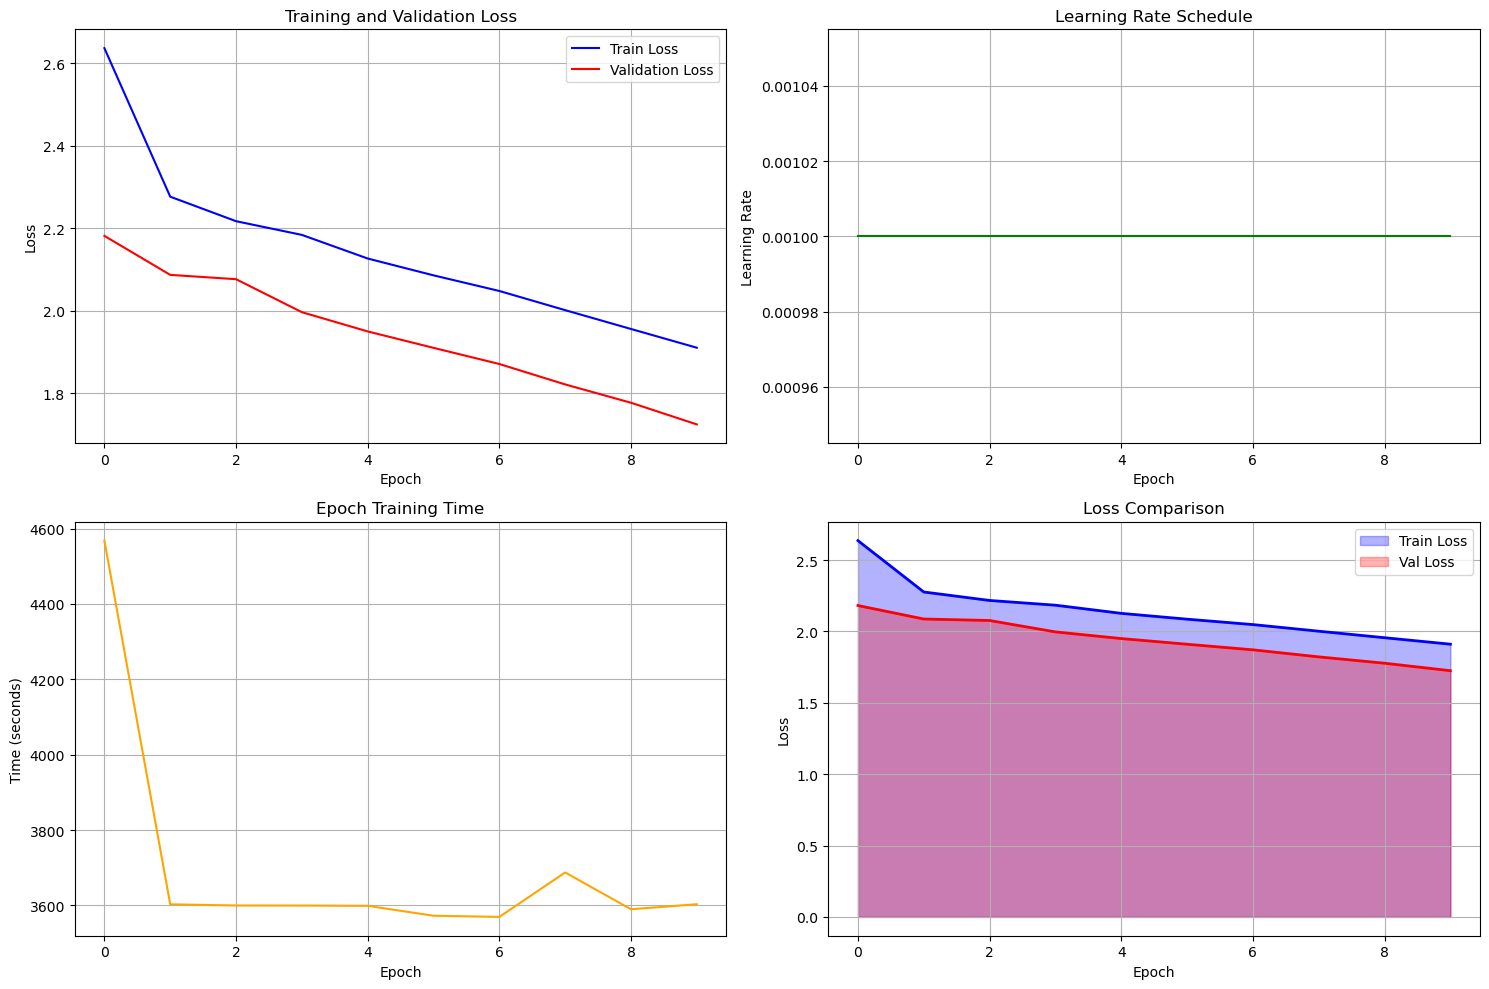

In [5]:


‘’‘’    # Train the model with comprehensive training loop

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from collections import defaultdict

class Trainer:
    """
    Trainer class for Seq2Seq machine translation model

    model: 要训练的模型，shape: 任意
    train_dataloader: 训练数据加载器
    val_dataloader: 验证数据加载器
    device: 训练设备（CPU 或 GPU）
    learning_rate: 学习率 (float，默认 1e-3)
    weight_decay: 权重衰减 (float，默认 1e-5)

    """
    def __init__(self, model, train_dataloader, val_dataloader, device,
                 learning_rate=1e-3, weight_decay=1e-5):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = device

        # Loss function - ignore padding tokens (index 0)
        '''
        self.criterion: 交叉熵损失函数，忽略填充标记（索引为 0）
        输入:
            预测值: (N, C) 其中 N 是样本数，C 是类别数
            真实值: (N,)
        输出: 标量损失值
        '''
        self.criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='mean')

        # Optimizer
        self.optimizer = optim.Adam(model.parameters(),
                                  lr=learning_rate,
                                  weight_decay=weight_decay)

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=2
        )

        # Training history
        self.history = defaultdict(list)

    '''
    计算批次损失
    outputs: 模型输出，shape: (batch_size, tgt_seq_len, decoder_vocab_size)
    targets: 目标序列，shape: (batch_size, tgt_seq_len)
    target_lengths: 目标序列长度（可选）
    '''
    def calculate_loss(self, outputs, targets, target_lengths=None):
        """Calculate loss for the batch"""
        # Reshape for loss calculation (use reshape instead of view for non-contiguous tensors)
        outputs_flat = outputs.reshape(-1, outputs.size(-1))    # 展平的输出，shape: (batch_size * tgt_seq_len, decoder_vocab_size)
        targets_flat = targets.reshape(-1)  # 展平的目标，shape: (batch_size * tgt_seq_len,)

        # Calculate loss
        loss = self.criterion(outputs_flat, targets_flat)

        return loss

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        epoch_loss = 0.0
        num_batches = 0

        progress_bar = tqdm(self.train_dataloader, desc="Training", leave=False)

        for batch_idx, batch in enumerate(progress_bar):
            # Move batch to device
            source_ids = batch['source_ids'].to(self.device)
            target_ids = batch['target_ids'].to(self.device)

            # Zero gradients
            self.optimizer.zero_grad()

            # Forward pass with teacher forcing
            decoder_input = target_ids[:, :-1]  # Remove last token
            decoder_targets = target_ids[:, 1:]  # Remove first token (BOS)

            outputs = self.model(source_ids, decoder_input)

            # Calculate loss
            loss = self.calculate_loss(outputs, decoder_targets)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Update parameters
            self.optimizer.step()

            # Update metrics
            epoch_loss += loss.item()
            num_batches += 1

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{epoch_loss / num_batches:.4f}'
            })

            # Memory cleanup
            if batch_idx % 100 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()

        return epoch_loss / num_batches

    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        epoch_loss = 0.0
        num_batches = 0

        progress_bar = tqdm(self.val_dataloader, desc="Validation", leave=False)

        with torch.no_grad():
            for batch in progress_bar:
                # Move batch to device
                source_ids = batch['source_ids'].to(self.device)
                target_ids = batch['target_ids'].to(self.device)

                # Forward pass
                decoder_input = target_ids[:, :-1]
                decoder_targets = target_ids[:, 1:]

                outputs = self.model(source_ids, decoder_input)

                # Calculate loss
                loss = self.calculate_loss(outputs, decoder_targets)

                # Update metrics
                epoch_loss += loss.item()
                num_batches += 1

                # Update progress bar
                progress_bar.set_postfix({
                    'Val Loss': f'{loss.item():.4f}',
                    'Avg Val Loss': f'{epoch_loss / num_batches:.4f}'
                })

        return epoch_loss / num_batches

    def train(self, num_epochs=10, save_path=None):
        """Train the model for specified number of epochs"""
        print(f"=== Starting Training for {num_epochs} Epochs ===")
        print(f"Device: {self.device}")
        print(f"Train batches: {len(self.train_dataloader)}")
        print(f"Validation batches: {len(self.val_dataloader)}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print("=" * 60)

        best_val_loss = float('inf')
        start_time = time.time()

        for epoch in range(num_epochs):
            epoch_start_time = time.time()

            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            print("-" * 40)

            # Train
            train_loss = self.train_epoch()

            # Validate
            val_loss = self.validate_epoch()

            # Update learning rate scheduler
            self.scheduler.step(val_loss)

            # Calculate epoch time
            epoch_time = time.time() - epoch_start_time

            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['epoch_time'].append(epoch_time)
            self.history['learning_rate'].append(self.optimizer.param_groups[0]['lr'])

            # Print epoch summary
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")
            print(f"Epoch Time: {epoch_time:.2f}s")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print(f"New best validation loss: {best_val_loss:.4f}")

                if save_path:
                    torch.save({
                        'epoch': epoch + 1,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'train_loss': train_loss,
                        'val_loss': val_loss,
                        'model_config': model_config
                    }, save_path)
                    print(f"Model saved to {save_path}")

            # Memory cleanup
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # Training summary
        total_time = time.time() - start_time
        print(f"\n{'='*60}")
        print(f"Training completed in {total_time:.2f}s ({total_time/60:.2f} min)")
        print(f"Best validation loss: {best_val_loss:.4f}")
        print(f"Final train loss: {self.history['train_loss'][-1]:.4f}")
        print(f"Final val loss: {self.history['val_loss'][-1]:.4f}")

        return self.history

    def plot_training_history(self):
        """Plot training history"""
        if not self.history['train_loss']:
            print("No training history to plot")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Plot loss
        axes[0, 0].plot(self.history['train_loss'], label='Train Loss', color='blue')
        axes[0, 0].plot(self.history['val_loss'], label='Validation Loss', color='red')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Plot learning rate
        axes[0, 1].plot(self.history['learning_rate'], color='green')
        axes[0, 1].set_title('Learning Rate Schedule')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Learning Rate')
        axes[0, 1].grid(True)

        # Plot epoch time
        axes[1, 0].plot(self.history['epoch_time'], color='orange')
        axes[1, 0].set_title('Epoch Training Time')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Time (seconds)')
        axes[1, 0].grid(True)

        # Plot loss comparison
        x = range(len(self.history['train_loss']))
        axes[1, 1].fill_between(x, self.history['train_loss'], alpha=0.3, color='blue', label='Train Loss')
        axes[1, 1].fill_between(x, self.history['val_loss'], alpha=0.3, color='red', label='Val Loss')
        axes[1, 1].plot(self.history['train_loss'], color='blue', linewidth=2)
        axes[1, 1].plot(self.history['val_loss'], color='red', linewidth=2)
        axes[1, 1].set_title('Loss Comparison')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()

# Initialize trainer
trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    learning_rate=1e-3,
    weight_decay=1e-5
)

# Start training for 10 epochs
print("Starting training...")
history = trainer.train(num_epochs=10, save_path="best_seq2seq_transformer_model.pth")

# Plot training history
print("\nPlotting training history...")
trainer.plot_training_history()


Continuing training from checkpoint...
=== Starting Training for 10 Epochs ===
Device: cuda
Train batches: 16950
Validation batches: 893
Model parameters: 24,439,944

Epoch 1/10
----------------------------------------


Train Loss: 1.8565
Val Loss: 1.6633
Learning Rate: 0.001000
Epoch Time: 8651.34s
New best validation loss: 1.6633
Model saved to continued_seq2seq_transformer_model.pth

Epoch 2/10
----------------------------------------


Train Loss: 1.7997
Val Loss: 1.6107
Learning Rate: 0.001000
Epoch Time: 6145.07s
New best validation loss: 1.6107
Model saved to continued_seq2seq_transformer_model.pth

Epoch 3/10
----------------------------------------


Train Loss: 1.7563
Val Loss: 1.5799
Learning Rate: 0.001000
Epoch Time: 5738.05s
New best validation loss: 1.5799
Model saved to continued_seq2seq_transformer_model.pth

Epoch 4/10
----------------------------------------


Train Loss: 1.7251
Val Loss: 1.5552
Learning Rate: 0.001000
Epoch Time: 5555.96s
New best validation loss: 1.5552
Model saved to continued_seq2seq_transformer_model.pth

Epoch 5/10
----------------------------------------


Train Loss: 1.7034
Val Loss: 1.5322
Learning Rate: 0.001000
Epoch Time: 5440.24s
New best validation loss: 1.5322
Model saved to continued_seq2seq_transformer_model.pth

Epoch 6/10
----------------------------------------


Train Loss: 1.6863
Val Loss: 1.5222
Learning Rate: 0.001000
Epoch Time: 5568.18s
New best validation loss: 1.5222
Model saved to continued_seq2seq_transformer_model.pth

Epoch 7/10
----------------------------------------


Train Loss: 1.6720
Val Loss: 1.5082
Learning Rate: 0.001000
Epoch Time: 5521.67s
New best validation loss: 1.5082
Model saved to continued_seq2seq_transformer_model.pth

Epoch 8/10
----------------------------------------


Train Loss: 1.6555
Val Loss: 1.4929
Learning Rate: 0.001000
Epoch Time: 6090.13s
New best validation loss: 1.4929
Model saved to continued_seq2seq_transformer_model.pth

Epoch 9/10
----------------------------------------


Train Loss: 1.6380
Val Loss: 1.4838
Learning Rate: 0.001000
Epoch Time: 5739.36s
New best validation loss: 1.4838
Model saved to continued_seq2seq_transformer_model.pth

Epoch 10/10
----------------------------------------


Train Loss: 1.6257
Val Loss: 1.4648
Learning Rate: 0.001000
Epoch Time: 6638.96s
New best validation loss: 1.4648
Model saved to continued_seq2seq_transformer_model.pth

Training completed in 61093.17s (1018.22 min)
Best validation loss: 1.4648
Final train loss: 1.6257
Final val loss: 1.4648
Training completed.

Plotting training history...


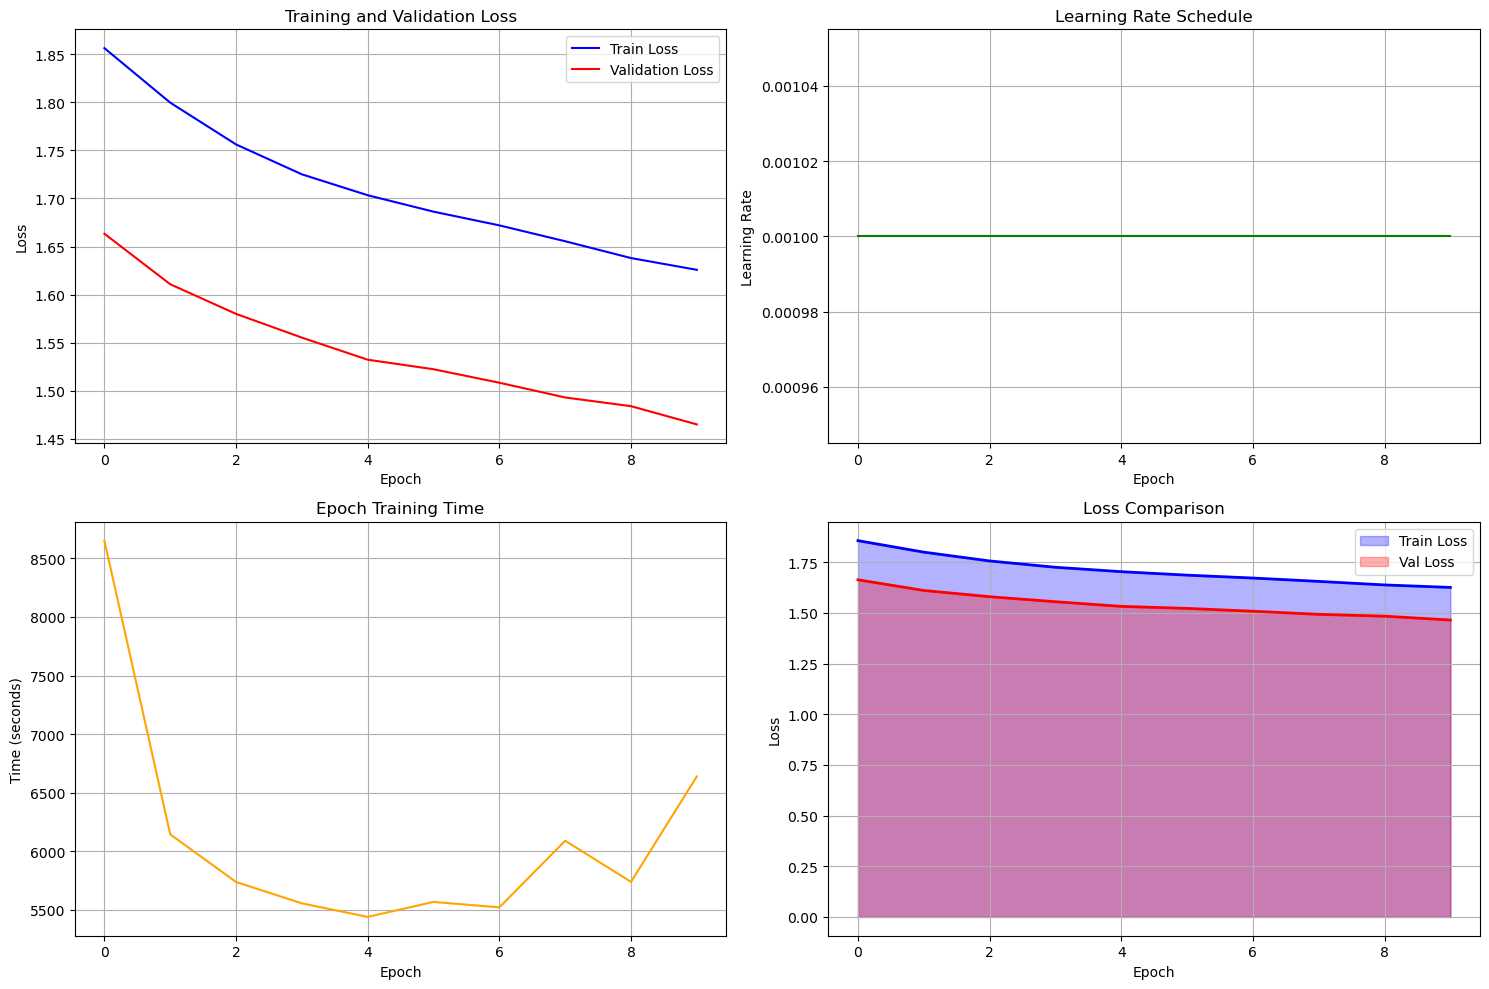

In [14]:
# 继续训练

# 加载保存的检查点
checkpoint_path = "best_seq2seq_transformer_model.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# 恢复模型状态
model.load_state_dict(checkpoint['model_state_dict'])

# 初始化 trainer（使用与之前相同的参数）
trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    learning_rate=1e-3,  # 可以根据需要调整学习率
    weight_decay=1e-5
)

# 恢复优化器状态
trainer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 如果需要继续训练更多轮次，可以指定新的轮次数
additional_epochs = 10

# 继续训练
print("Continuing training from checkpoint...")
history = trainer.train(num_epochs=additional_epochs, save_path="continued_seq2seq_transformer_model.pth")
print("Training completed.")

# 绘制训练历史
print("\nPlotting training history...")
trainer.plot_training_history()

In [15]:
# Fixed Comprehensive Machine Translation Testing Code for Transformer Model

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer
import numpy as np
from collections import Counter
import re
import time
import math

class TransformerTranslationTester:
    """
    Comprehensive tester for the Transformer machine translation model
    """
    def __init__(self, model, device, max_length=100):
        self.model = model
        self.device = device
        self.max_length = max_length

        # Load tokenizers
        self.tokenizer_en = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.tokenizer_zh = AutoTokenizer.from_pretrained("bert-base-chinese")

        # Special tokens
        self.bos_token = 101  # [CLS] token used as BOS
        self.eos_token = 102  # [SEP] token used as EOS
        self.pad_token = 0    # [PAD] token

        print("=== Transformer Translation Tester Initialized ===")
        print(f"Device: {device}")
        print(f"English tokenizer vocab size: {self.tokenizer_en.vocab_size}")
        print(f"Chinese tokenizer vocab size: {self.tokenizer_zh.vocab_size}")
        print(f"Max sequence length: {max_length}")

    def preprocess_text(self, text):
        """Clean and preprocess input text"""
        # Basic cleaning
        text = text.strip()
        text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single space
        return text

    def encode_english(self, text):
        """Encode English text to token IDs"""
        text = self.preprocess_text(text)
        tokens = self.tokenizer_en(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return tokens['input_ids'].to(self.device)

    def decode_chinese(self, token_ids):
        """Decode Chinese token IDs to text"""
        # Remove padding tokens and special tokens
        if isinstance(token_ids, torch.Tensor):
            token_ids = token_ids.cpu().tolist()

        # Remove padding (0), BOS (101), and EOS (102) tokens
        cleaned_tokens = []
        for token_id in token_ids:
            if token_id not in [0, 101, 102]:
                cleaned_tokens.append(token_id)
            elif token_id == 102:  # Stop at EOS token
                break

        if not cleaned_tokens:
            return "[Empty translation]"

        try:
            text = self.tokenizer_zh.decode(cleaned_tokens, skip_special_tokens=True)
            # Clean up extra spaces for Chinese
            text = re.sub(r'\s+', '', text)  # Remove all spaces for Chinese
            return text if text else "[Empty translation]"
        except Exception as e:
            return f"[Decoding error: {str(e)}]"

    def translate_single(self, english_text, use_beam_search=False, beam_size=3, temperature=1.0):
        """
        Translate a single English sentence to Chinese

        Args:
            english_text: Input English text
            use_beam_search: Whether to use beam search (simplified implementation)
            beam_size: Beam search size (only used if use_beam_search=True)
            temperature: Sampling temperature for generation
        """
        self.model.eval()

        with torch.no_grad():
            # Encode input
            source_ids = self.encode_english(english_text)

            if not use_beam_search:
                # Use the model's built-in greedy generation
                generated = self.model.generate(
                    source_ids,
                    max_length=self.max_length,
                    bos_token=self.bos_token,
                    eos_token=self.eos_token,
                    pad_token=self.pad_token
                )
                translation = self.decode_chinese(generated[0])
            else:
                # Use simplified beam search
                translation = self._beam_search_translate(source_ids, beam_size, temperature)

        return translation

    def _beam_search_translate(self, source_ids, beam_size=3, temperature=1.0):
        """
        Simplified beam search implementation for Transformer model
        """
        batch_size = source_ids.size(0)
        device = source_ids.device

        # Encode source
        src_mask = self.model.create_padding_mask(source_ids)
        encoder_output = self.model.encode(source_ids, src_mask)

        # Initialize beams: (sequence, score)
        beams = [(torch.tensor([[self.bos_token]], device=device), 0.0)]

        for step in range(self.max_length):
            new_beams = []

            for seq, score in beams:
                # If sequence already ended, keep it
                if seq[0, -1].item() == self.eos_token:
                    new_beams.append((seq, score))
                    continue

                # Create masks for current sequence
                tgt_mask = self.model.create_padding_mask(seq) & \
                          self.model.create_look_ahead_mask(seq.size(1)).to(device)

                # Get decoder output
                decoder_output = self.model.decode(seq, encoder_output, tgt_mask, src_mask)

                # Get next token probabilities
                logits = self.model.output_projection(decoder_output[:, -1, :])

                # Apply temperature
                if temperature != 1.0:
                    logits = logits / temperature

                # Get probabilities
                probs = F.softmax(logits, dim=-1)

                # Get top k candidates
                top_probs, top_indices = torch.topk(probs, min(beam_size, probs.size(-1)))

                for i in range(top_probs.size(1)):
                    token_id = top_indices[0, i].unsqueeze(0).unsqueeze(0)
                    token_prob = top_probs[0, i].item()
                    new_seq = torch.cat([seq, token_id], dim=1)
                    new_score = score + math.log(token_prob + 1e-10)
                    new_beams.append((new_seq, new_score))

            # Keep only top beams
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]

            # Check if all beams ended
            if all(seq[0, -1].item() == self.eos_token for seq, _ in beams):
                break

        # Return best beam
        best_seq = beams[0][0]
        return self.decode_chinese(best_seq[0])

    def calculate_bleu_score(self, reference, candidate):
        """
        Calculate BLEU score (simplified version)
        """
        def get_ngrams(tokens, n):
            return [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

        # Tokenize (character-level for Chinese)
        ref_tokens = list(reference.replace(' ', ''))
        cand_tokens = list(candidate.replace(' ', ''))

        if len(cand_tokens) == 0:
            return 0.0

        # Calculate precision for n-grams (1 to 4)
        precisions = []
        for n in range(1, 5):
            ref_ngrams = Counter(get_ngrams(ref_tokens, n))
            cand_ngrams = Counter(get_ngrams(cand_tokens, n))

            if len(cand_ngrams) == 0:
                precisions.append(0.0)
                continue

            matches = sum((ref_ngrams & cand_ngrams).values())
            precision = matches / len(get_ngrams(cand_tokens, n))
            precisions.append(precision)

        # Calculate brevity penalty
        ref_len = len(ref_tokens)
        cand_len = len(cand_tokens)

        if cand_len > ref_len:
            bp = 1.0
        else:
            bp = math.exp(1 - ref_len / (cand_len + 1e-10))

        # Calculate BLEU score
        if min(precisions) == 0:
            return 0.0

        bleu = bp * math.exp(sum(math.log(p + 1e-10) for p in precisions) / 4)
        return bleu

    def test_examples(self, test_cases, use_beam_search=False, beam_size=3, temperature=1.0):
        """
        Test the model on multiple examples
        """
        print("\n" + "="*80)
        print("MACHINE TRANSLATION TESTING RESULTS")
        print("="*80)
        print(f"Model: Transformer (Attention is All You Need)")
        print(f"Decoding: {'Beam Search' if use_beam_search else 'Greedy'}")
        if use_beam_search:
            print(f"Beam size: {beam_size}")
            print(f"Temperature: {temperature}")
        print("-"*80)

        results = []
        total_time = 0

        for i, (english, expected_chinese) in enumerate(test_cases, 1):
            print(f"\nTest {i}/{len(test_cases)}")
            print("-" * 40)
            print(f"English:  {english}")

            # Translate
            start_time = time.time()
            translation = self.translate_single(english, use_beam_search, beam_size, temperature)
            translation_time = time.time() - start_time
            total_time += translation_time

            print(f"Expected: {expected_chinese}")
            print(f"Generated: {translation}")
            print(f"Time: {translation_time:.3f}s")

            # Calculate BLEU score if reference is provided
            if expected_chinese and expected_chinese != "":
                bleu_score = self.calculate_bleu_score(expected_chinese, translation)
                print(f"BLEU Score: {bleu_score:.4f}")
            else:
                bleu_score = None
                print("BLEU Score: N/A (no reference)")

            results.append({
                'english': english,
                'expected': expected_chinese,
                'translation': translation,
                'time': translation_time,
                'bleu': bleu_score
            })

        # Summary statistics
        print("\n" + "="*80)
        print("SUMMARY STATISTICS")
        print("="*80)
        print(f"Total examples: {len(test_cases)}")
        print(f"Total time: {total_time:.3f}s")
        print(f"Average time per translation: {total_time/len(test_cases):.3f}s")

        bleu_scores = [r['bleu'] for r in results if r['bleu'] is not None]
        if bleu_scores:
            print(f"Average BLEU score: {np.mean(bleu_scores):.4f}")
            print(f"Max BLEU score: {max(bleu_scores):.4f}")
            print(f"Min BLEU score: {min(bleu_scores):.4f}")

        return results

    def interactive_translation(self):
        """Interactive translation mode"""
        print("\n" + "="*60)
        print("INTERACTIVE TRANSLATION MODE")
        print("="*60)
        print("Enter English text to translate (type 'quit' to exit)")
        print("Type 'beam' to toggle beam search mode")
        print("-"*60)

        use_beam_search = False

        while True:
            try:
                user_input = input(f"\nEnglish ({'Beam' if use_beam_search else 'Greedy'}): ").strip()

                if user_input.lower() in ['quit', 'exit', 'q']:
                    print("Goodbye!")
                    break

                if user_input.lower() == 'beam':
                    use_beam_search = not use_beam_search
                    print(f"Switched to {'Beam Search' if use_beam_search else 'Greedy'} mode")
                    continue

                if not user_input:
                    print("Please enter some text.")
                    continue

                # Translate
                start_time = time.time()
                translation = self.translate_single(user_input, use_beam_search=use_beam_search)
                translation_time = time.time() - start_time

                print(f"Chinese:  {translation}")
                print(f"Time: {translation_time:.3f}s")

            except KeyboardInterrupt:
                print("\nGoodbye!")
                break
            except Exception as e:
                print(f"Error: {str(e)}")

# Test cases for English to Chinese translation
TRANSFORMER_TEST_CASES = [
    # Basic greetings and common phrases
    ("Hello", "你好"),
    ("Good morning", "早上好"),
    ("Thank you", "谢谢"),
    ("Nice to meet you", "很高兴见到你"),
    ("Goodbye", "再见"),

    # Simple sentences
    ("I love you", "我爱你"),
    ("What is your name?", "你叫什么名字？"),
    ("Where are you from?", "你来自哪里？"),
    ("How are you?", "你好吗？"),
    ("Can you help me?", "你能帮助我吗？"),

    # Daily life
    ("I am hungry", "我饿了"),
    ("The weather is nice", "天气很好"),
    ("I need to go to work", "我需要去工作"),
    ("Let's have dinner", "我们吃晚饭吧"),
    ("I am learning Chinese", "我在学中文"),

    # Without reference translations (for testing only)
    ("Machine learning is important", ""),
    ("I like to read books", ""),
    ("The cat is sleeping", ""),
    ("Tomorrow is Monday", ""),
    ("Coffee tastes good", ""),
]

# Initialize the corrected tester
print("Initializing Transformer translation tester...")
transformer_tester = TransformerTranslationTester(model, device, max_length=100)

# Check if model was trained
has_trained_model = 'history' in globals() and history is not None
if not has_trained_model:
    print("\n" + "="*80)
    print("WARNING: Model appears to be untrained!")
    print("="*80)
    print("The model has not been trained yet, so translations will be random.")
    print("To get meaningful results, you should train the model first.")
    print("You can still test the translation pipeline, but expect poor quality.")
    print("="*80)

# Test with simple examples first (Greedy decoding)
print("\n" + "="*80)
print("TESTING SIMPLE EXAMPLES (Greedy Decoding)")
print("="*80)
simple_results = transformer_tester.test_examples(TRANSFORMER_TEST_CASES[:3], use_beam_search=False)

# Test one example with beam search
print("\n" + "="*80)
print("TESTING WITH BEAM SEARCH")
print("="*80)
beam_results = transformer_tester.test_examples(TRANSFORMER_TEST_CASES[3:4], use_beam_search=True, beam_size=3, temperature=0.8)

# Quick performance test
print("\n" + "="*80)
print("QUICK PERFORMANCE TEST")
print("="*80)

test_sentences = [
    "Hello",
    "I am happy",
    "The weather is nice today"
]

print("Testing translation speed:")
print("-" * 40)

for i, sentence in enumerate(test_sentences, 1):
    start_time = time.time()
    translation = transformer_tester.translate_single(sentence)
    end_time = time.time()

    print(f"Test {i}: {end_time - start_time:.3f}s")
    print(f"  Input:  {sentence}")
    print(f"  Output: {translation}")
    print()

print("="*80)
print("TRANSFORMER TESTING COMPLETE")
print("="*80)
print("You can now use:")
print("- transformer_tester.translate_single('your text here')")
print("- transformer_tester.interactive_translation()")
print("- transformer_tester.test_examples(your_test_cases)")
print("="*80)

Initializing Transformer translation tester...
=== Transformer Translation Tester Initialized ===
Device: cuda
English tokenizer vocab size: 30522
Chinese tokenizer vocab size: 21128
Max sequence length: 100

TESTING SIMPLE EXAMPLES (Greedy Decoding)

MACHINE TRANSLATION TESTING RESULTS
Model: Transformer (Attention is All You Need)
Decoding: Greedy
--------------------------------------------------------------------------------

Test 1/3
----------------------------------------
English:  Hello
Expected: 你好
Generated: 喂,你好吗?
Time: 0.036s
BLEU Score: 0.0000

Test 2/3
----------------------------------------
English:  Good morning
Expected: 早上好
Generated: 早上好好好
Time: 0.015s
BLEU Score: 0.0000

Test 3/3
----------------------------------------
English:  Thank you
Expected: 谢谢
Generated: 谢谢你
Time: 0.015s
BLEU Score: 0.0000

SUMMARY STATISTICS
Total examples: 3
Total time: 0.067s
Average time per translation: 0.022s
Average BLEU score: 0.0000
Max BLEU score: 0.0000
Min BLEU score: 0.0000

T

In [26]:
testString = "This satisfied the kids, but not the husband."
print(testString)
transformer_tester.translate_single(testString)

This satisfied the kids, but not the husband.


'这个孩子们的意见，但是不是丈夫。'